<center>
    <h1>Tarea 3 ANN</h1>
    <h2>Recurrent Neural Networks</h2>
    <br>
    <h3>Diego Pérez - 201173045-3</h3>
    <h3>Ariel Sanhueza - ROL</h3>
</center>

### Importación de módulos a utilizar durante los experimentos.

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import load_model

### RNN en series de tiempo

Se utilizará el dataset International Airline Passengers y el objetivo de la red a entrenar será predecir el número de pasajeros en vuelos internacionales.

#### a) Cargar, dividir y escalar el dataset

Se utilizará el MinMaxScaler en el rango (0,1), es decir, se tomará el menor y mayor valor del dataset y se asignarán como 0 y 1 respectivamente. Todos los demas valores del dataset se escalarán apropiadamente en base al máximo y mínimo.

In [2]:
### LOAD THE DATASET
url = 'http://www.inf.utfsm.cl/~cvalle/international-airline-passengers.csv'
dataframe = pd.read_csv(url, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32')

In [9]:
### SPLIT INTO TRAINING AND TEST SETS
df_train, df_test = dataframe[0:96].values, dataframe[96:].values
### SCALE BOTH SETS USING THE SAME MINMAXSCALER
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

Con los datos ya divididos y escalados, es necesario construir la matriz de entrada para las RNN, a partir de la serie de tiempo.

#### b) Transformar entrada

La siguiente función transforma un vector de entrada (serie de tiempo) considerando un lag como parámentro, para poder ser utilizado como input de las RNN.

In [22]:
def create_dataset(ts, lag=1):
    dataX = np.array([])
    for index in range(lag, len(ts)):
        dataX = np.append(dataX, np.array([ts[index-lag:index]]))
    return dataX.reshape(len(ts)-lag, lag), ts[lag:]

#### c) Crear datsets

Usando lag igual a 3, se crean los dataset de entrenamiento y pruebas.

In [40]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (93, 3)
Conjunto de pruebas con lag=3:  (45, 3)


#### d) Transformación para LSTM

Para poder usar el dataset en una LSTM, necesitamos entradas de la forma [samples, time steps, features].

In [41]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (93, 1, 3)
Conjunto de pruebas con lag=3:  (45, 1, 3)


#### e) Entrenamiento

Con las entradas en el formato correcto, generamos el modelo de la red, para luego entrenarla.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_4 (LSTM)                    (None, 4)             128         lstm_input_4[0][0]               
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1)             5           lstm_4[0][0]                     
Total params: 133
____________________________________________________________________________________________________


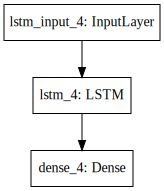

In [46]:
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

La inicialización de los pesos es por Gaussiana escalada, como se propone en Glorot, 2010. Para los pesos internos, se usa inicialización ortogonal, donde la matriz obtenida tiene eigenvalues igual a 1, atenuando el problema de vanishing gradient.
Los parámetros por defecto del optimizador Adam son:
* learning rate = 0.001
* beta_1 = 0.9
* beta_2 = 0.999

In [ ]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
model.save('RNN-lag3.h5')

#### f) Predicción y desnormalización.

Se realiza la predicción para los conjuntos de entrenamiento y pruebas, desnormalizando los datos para obtener el error en la escala original.

In [49]:
# LOAD MODEL
model = load_model('RNN-lag3.h5')
# PREDICT SETS
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# DENORMALIZE PREDICTIONS
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Exception: Optimizer weight shape (3, 4) not compatible with provided weight shape (4,)

#### g) RSME